<a href="https://colab.research.google.com/github/Olimaol/notebooks-deeprl/blob/main/solutions-output/10-Eligibilitytraces.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eligibility traces

The goal of this exercise is to study the effect of eligibility traces in the simple Gridworld environment.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame swig
    !pip install moviepy==1.0.3

In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os
# os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg" # if moviepy complains about not finding ffmpeg, put its path here
import gymnasium as gym
print("gym version:", gym.__version__)

import pygame
from moviepy.editor import ImageSequenceClip
from IPython.display import Image, display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename, show=True):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []
        if show:
            display(Image(filename=filename))

def running_average(x, N):
    kernel = np.ones(N) / N
    return np.convolve(x, kernel, mode='same')

gym version: 1.2.1


/opt/hostedtoolcache/Python/3.12.11/x64/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Q-learning in Gridworld

### Random interaction with the environment

The goal of this exercise is to solve the **Gridworld** problem using Q-learning. The code is adapted from  <https://gymnasium.farama.org/tutorials/environment_creation/>

The agent is represented by the blue circle: the **state** $s$ of the agent is its position in the 5x5 grid, i.e. a number between 0 and 24.

The agent can move either to the left, right, top or bottom. When the agent tries to move outside of the environment, it stays at its current position. There are four **actions** $a$ available, which are deterministic.    

Its goal is to reach the green circle, while avoiding the red ones. Actions leading to the green circle receive a reward $r$ of +100, actions leading to a red square receive a reward of -100. The episode ends in those states. All other actions have a reward of -1. An episode stops after 100 steps if a goal has not been reached.

The code of the environment is provided below. It is not important to understand it completely, but feel free to have a look at it. Rendering uses the `pygame` library, a well-known framework for simple games.

In [3]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array", "rgb_array_list"], "render_fps": 2}

    def __init__(self, render_mode=None, size=5, rewards=[100, -100, -1]):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.rewards = rewards
        self._step = 0

        # The state is the flattened (x, y) coordinate of the agent
        self.observation_space = gym.spaces.Discrete(size**2)

        # Goal location
        self._target_location = np.array([3, 2], dtype=int)
        self._distractor1_location = np.array([3, 1], dtype=int)
        self._distractor2_location = np.array([2, 2], dtype=int)

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(4)

        self._action_to_direction = {
            0: np.array([1, 0]), # right
            1: np.array([0, 1]), # down
            2: np.array([-1, 0]), # left
            3: np.array([0, -1]), # up
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        if self.render_mode == "rgb_array_list":
            self._frames = []
        self.window = None
        self.clock = None
        self.font = pygame.font.SysFont(None, 16)
        self.Q = np.zeros((self.observation_space.n, self.action_space.n))


    def _state2coordinates(self, state):
        "Returns coordinates of a state."
        return (state % self.size, int(state/self.size))

    def _coordinate2state(self, coord):
        "Returns the state with the coordinates."
        return coord[1] * self.size + coord[0]

    def reset(self, seed=None, options=None):

        self._step = 0

        # Initial location
        self._agent_location = np.array([0, 0], dtype=int)

        if self.render_mode == "human":
            self._render_frame()
        
        if self.render_mode == "rgb_array_list":
            self._frames = []
            self._render_frame()

        return self._coordinate2state(self._agent_location), {}


    def step(self, action):

        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        
        # An episode is done if the agent has reached the target or the distractors
        if np.array_equal(self._agent_location, self._target_location):
            terminal = True
            reward = self.rewards[0]
        elif np.array_equal(self._agent_location, self._distractor1_location) \
            or np.array_equal(self._agent_location, self._distractor2_location):
            terminal = True
            reward = self.rewards[1]
        else:
            terminal = False
            reward = self.rewards[2]

        if self.render_mode == "human" or self.render_mode == "rgb_array_list":
            self._render_frame()

        self._step += 1
        if self._step == 100:
            truncated = True
        else:
            truncated = False

        return self._coordinate2state(self._agent_location), reward, terminal, truncated, {}

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()
        elif self.render_mode == "rgb_array_list":
            f = self._frames.copy()
            self._frames = []
            return f

    def _render_frame(self):

        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target and the distractors
        pygame.draw.rect(
            canvas,
            (0, 255, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._distractor1_location,
                (pix_square_size, pix_square_size),
            ),
        )
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._distractor2_location,
                (pix_square_size, pix_square_size),
            ),
        )

        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        # Print Q-values
        for x in range(self.size):
            for y in range(self.size):
                s = self._coordinate2state((x, y))
                
                # Up
                val = f"{self.Q[s, 3]:+.2f}"
                text = self.font.render(val, True, (0, 0, 0))
                canvas.blit(text, 
                    ((x + 0.5) * pix_square_size - 6, 
                    (y) * pix_square_size + 6)
                )
                # Down
                val = f"{self.Q[s, 1]:+.2f}"
                text = self.font.render(val, True, (0, 0, 0))
                canvas.blit(text, 
                    ((x + 0.5) * pix_square_size - 6, 
                    (y+1) * pix_square_size - 12)
                )
                # Left
                val = f"{self.Q[s, 2]:+.2f}"
                text = self.font.render(val, True, (0, 0, 0))
                canvas.blit(text, 
                    ((x) * pix_square_size + 6, 
                    (y+ 0.5) * pix_square_size - 6)
                )
                # Right
                val = f"{self.Q[s, 0]:+.2f}"
                text = self.font.render(val, True, (0, 0, 0))
                canvas.blit(text, 
                    ((x + 1) * pix_square_size - 32, 
                    (y+ 0.5) * pix_square_size - 6)
                )


        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])

        elif  self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        elif  self.render_mode == "rgb_array_list":
            array = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
            self._frames.append(array)

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

Let's now define a random agent that just defines the interaction loop:

In [4]:
class RandomAgent:
    
    def __init__(self, env):
        self.env = env
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        
    def act(self, state):
        "Selects an action randomly"
        return self.env.action_space.sample()
    
    def test(self, nb_episodes, recorder=None):
        "Runs the agent on the environment for nb_episodes."
        # Returns
        returns = []
        steps = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            return_episode = 0.0

            # Sample the episode
            while not done:
                    
                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)
                
                # Append reward
                return_episode += reward

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1

                # Terminal state
                done = terminal or truncated
                
                # Pass the Q table to the GUI
                self.env.Q = self.Q  

            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)

        if recorder is not None:
            recorder.record(self.env.render())
            
        return returns, steps

We can now run the interaction loop. If not in Colab, you can also set the `render_mode` to `'human'` and remove the recorder to see it in a window. Setting the parameter to `None` would switch off rendering.

MoviePy - Building file videos/gridworld-random.gif with imageio.


t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]

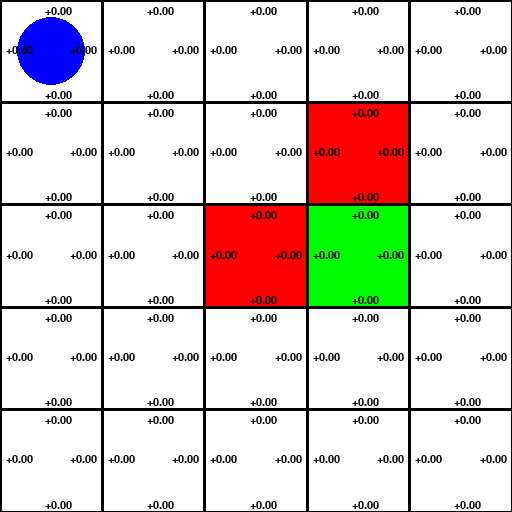

In [5]:
# Create the environment
env = GridWorldEnv(render_mode='rgb_array_list')

recorder = GymRecorder(env)

# Create the agent
agent = RandomAgent(env)

# Perform random episodes
returns, steps = agent.test(10, recorder)

recorder.make_video("videos/gridworld-random.gif")

**Q:** Adapt your Q-learning agent from last exercise to the problem. The main difference is the call to `self.env.Q = self.Q` so that the GUI displays the Q-values, the rest is similar. Train it for 100 episodes with the right hyperparameters and without rendering.

In [6]:
# Solution:
class QLearningAgent:
    """
    Q-learning agent.
    """
    
    def __init__(self, env, gamma, exploration, decay, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param exploration: exploration parameter
        :param decay: exploration decay parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.exploration = exploration
        self.decay = decay
        self.alpha = alpha
        
        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."
        
        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])
        
        if rng.random() < self.exploration:
            action = self.env.action_space.sample() 
        
        return action
    
    def update(self, state, action, reward, next_state, done):
        "Updates the agent using a single transition."
        
        # Bellman target
        target = reward
        
        if not done:
            target += self.gamma * self.Q[next_state, :].max()
        
        # Update the Q-value
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
            
        # Decay exploration parameter
        self.exploration = self.exploration * (1 - self.decay)
            
    
    def train(self, nb_episodes, recorder=None):
        "Runs the agent on the environment for nb_episodes."

        # Returns
        returns = []
        steps = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            return_episode = 0.0

            # Sample the episode
            while not done:

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)

                # Terminal state
                done = terminal or truncated
                
                # Append reward
                return_episode += reward

                # Learn from the transition
                self.update(state, action, reward, next_state, done)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                
                # Pass the Q table to the GUI
                self.env.Q = self.Q

            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)

            if recorder is not None:
                recorder.record(self.env.render())
            
        return returns, steps
    
    def test(self, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0
        
        # Reset
        state, info = self.env.reset()
        done = False
        nb_steps = 0
        return_episode= 0

        # Sample the episode
        while not done:
            action = self.act(state)
            next_state, reward, done, info = self.env.step(action)
            return_episode += reward
            state = next_state
            nb_steps += 1
            
        self.epsilon = previous_epsilon

        if recorder is not None:
            recorder.record(self.env.render())
            
        return return_episode, nb_steps

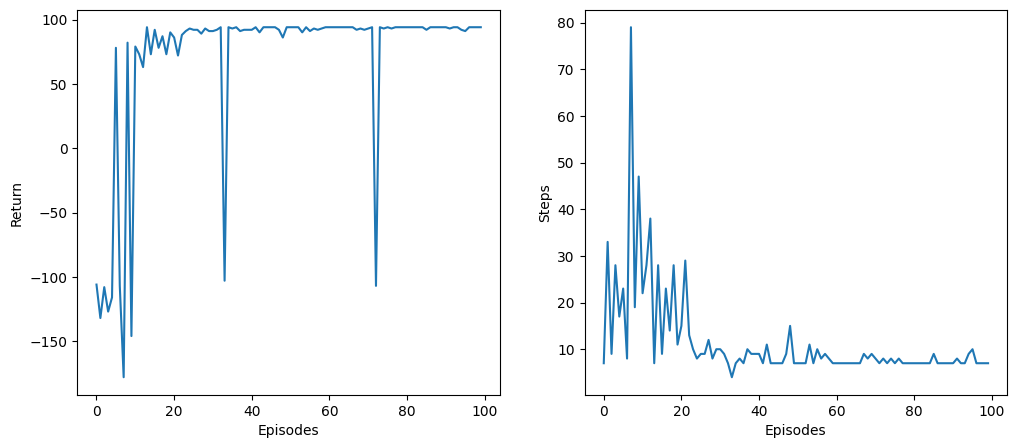

In [7]:
# Solution:
# Parameters
gamma = 0.99
epsilon = 0.1
decay_epsilon = 0
alpha = 0.1
nb_episodes = 100

# Create the environment
env = GridWorldEnv(render_mode=None)

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.subplot(122)
plt.plot(steps)
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.show()

**Q:** Train a Q-learning agent with rendering on. Observe in particular which Q-values are updated when the agent reaches the target. Is it efficient?

In [8]:
# Solution:
# Parameters
gamma = 0.99
epsilon = 0.1
decay_epsilon = 0
alpha = 0.1
nb_episodes = 10

# Create the environment
env = GridWorldEnv(render_mode='rgb_array_list')
recorder = GymRecorder(env)

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes, recorder)


MoviePy - Building file videos/gridworld-trained.gif with imageio.


t:   0%|          | 0/282 [00:00<?, ?it/s, now=None]

t:  67%|██████▋   | 190/282 [00:00<00:00, 1898.97it/s, now=None]

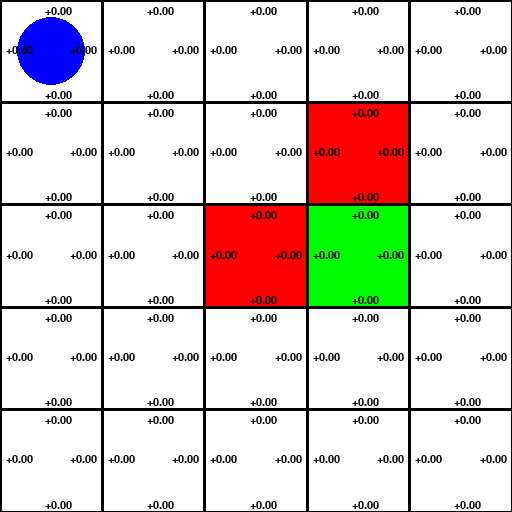

In [9]:
# Solution:
# Video
recorder.make_video("videos/gridworld-trained.gif")

**Q:** Modify your agent so that it uses **softmax action selection**, with a temperature $\tau = 1.0$ and a suitable decay. What does it change?

If you have time, write a generic class for the Q-learning agent where you can select the action selection method flexibly.

In [10]:
# Solution:
class SoftQLearningAgent(QLearningAgent):
    """
    Q-learning agent with softmax or e-greedy AS.
    """
    
    def __init__(self, env, gamma, action_selection, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param action selection: exploration mechanism
        :param alpha: learning rate
        """
        self.action_selection = action_selection
        
        super().__init__(env, gamma, action_selection['param'], action_selection['decay'], alpha)
    
    def act(self, state):
        "Returns an action using epsilon-greedy or softmax  action selection."
            
        if self.action_selection['type'] == "egreedy":
            # epsilon-greedy
            if rng.uniform(0, 1, 1) < self.exploration:
                action = self.env.action_space.sample() 
            else:
                action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])
        else: 
            # softmax
            logits = np.exp((self.Q[state, :] - self.Q[state, :].max())/self.exploration)
            probas = logits / np.sum(logits)
            action = rng.choice(range(4), p=probas) 
        
        return action
        

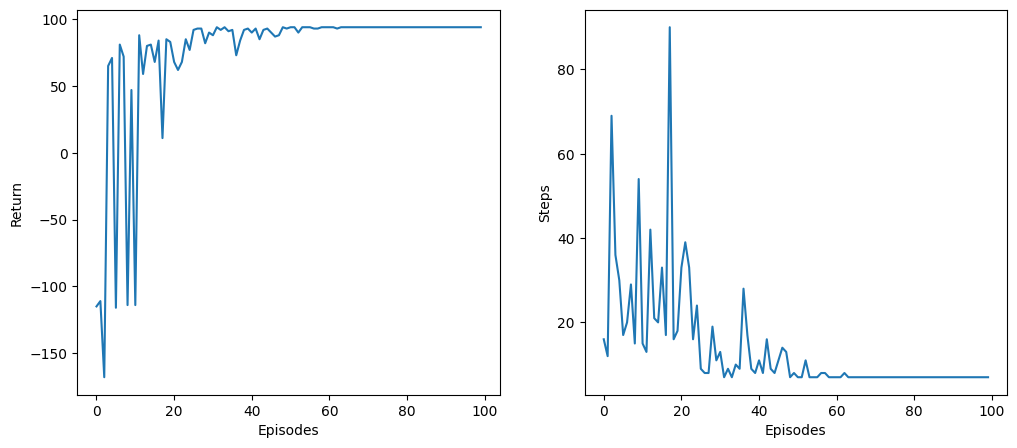

In [11]:
# Solution:
# Parameters
gamma = 0.99
#action_selection  = {'type': "egreedy", "param": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "param": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 100

# Create the environment
env = GridWorldEnv(render_mode=None)

# Create the agent
agent = SoftQLearningAgent(env, gamma, action_selection, alpha)

# Train the agent 
returns, steps = agent.train(nb_episodes)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.subplot(122)
plt.plot(steps)
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.show()

**A:** The agent explores much less at the end of training, as the difference between the Q-values becomes high enough to become greedy. In particular, it quickly stops to go to the red squares. In this environment, there is no real need to decay tau.

## Eligibility traces

The main drawback of Q-learning is that it needs many episodes to converge (**sample complexity**).

One way to speed up learning is to use eligibility traces, one per state-action pair:

```python
traces = np.zeros((nb_states, nb_actions))
```

After each transition $(s_t, a_t)$, Q($\lambda$) updates a **trace** $e(s_t, a_t)$ and modifies all Q-values as:

1.  The trace of the last transition is incremented from 1:
    
$$e(s_t, a_t) = e(s_t, a_t) +1$$
    
2. Q($\lambda$)-learning is applied on **ALL** Q-values, using the TD error at time $t$:
    
$$Q(s, a) = Q(s, a) + \alpha \, (r_{t+1} + \gamma \, \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t)) \, e(s, a)$$
    
3. All traces are exponentially decreased using the trace parameter $\lambda$ (e.g. 0.7):

$$
e(s, a) = \lambda \, \gamma \, e(s, a)
$$

All traces are reset to 0 at the beginning of an episode.

**Q:** Implement eligibility traces in your Q($\lambda$)-learning agent and see if it improves convergence. Train it with rendering on and observe how all Q-values are updated.

In [12]:
# Solution:
class QLambdaLearningAgent(SoftQLearningAgent):
    """
    Q(lambda)-learning agent with softmax or e-greedy AS and eligibility traces.
    """
    
    def __init__(self, env, gamma, lbda, action_selection, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param lbda: trace
        :param action selection: exploration mechanism
        :param alpha: learning rate
        """
        self.lbda = lbda
        
        # Traces
        self.traces = np.zeros([env.observation_space.n, env.action_space.n])
        
        super().__init__(env, gamma, action_selection, alpha)
        

    
    def update(self, state, action, reward, next_state, done):
        
        # Bellman target
        target = reward
        if not done:
            target += self.gamma * self.Q[next_state, :].max()
        
        # Update ALL Q-values
        self.Q += self.alpha * (target - self.Q[state, action]) * self.traces
            
        # Decay exploration parameter
        self.exploration = self.exploration * (1 - self.decay)
        
        
    def train(self, nb_episodes, recorder=None):
        "Runs the agent on the environment for nb_episodes."

        # Returns
        returns = []
        steps = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            nb_steps = 0
            
            # Reset traces
            self.traces *= 0.0

            # Store rewards
            return_episode = 0.0

            # Sample the episode
            while not done:

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)
                
                # Terminal state
                done = terminal or truncated
                
                # Update return 
                return_episode += reward
                
                # Increment trace
                self.traces[state, action] += 1

                # Learn from the transition
                self.update(state, action, reward, next_state, done)
                
                # Update all traces
                self.traces *= self.gamma * self.lbda

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
            
                
                # Pass the Q table to the GUI
                self.env.Q = self.Q

            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)

            if recorder is not None:
                recorder.record(self.env.render())

        return returns, steps

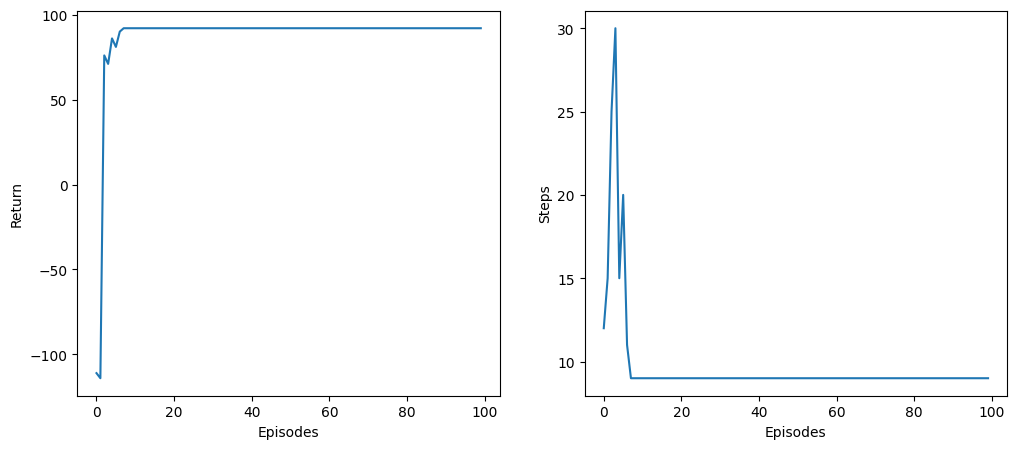

In [13]:
# Solution:
# Parameters
gamma = 0.99
lbda = 0.7
#action_selection  = {'type': "egreedy", "param": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "param": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 100

# Create the environment
env = GridWorldEnv(render_mode=None)

# Create the agent
agent = QLambdaLearningAgent(env, gamma, lbda, action_selection, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.subplot(122)
plt.plot(steps)
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.show()

In [14]:
# Solution:
# Parameters
gamma = 0.99
lbda = 0.7
#action_selection  = {'type': "egreedy", "param": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "param": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 10

# Create the environment
env = GridWorldEnv(render_mode='rgb_array_list')
recorder = GymRecorder(env)

# Create the agent
agent = QLambdaLearningAgent(env, gamma, lbda, action_selection, alpha)

# Train the agent
returns = agent.train(nb_episodes, recorder)

MoviePy - Building file videos/gridworld-traces.gif with imageio.


t:   0%|          | 0/502 [00:00<?, ?it/s, now=None]

t:  38%|███▊      | 193/502 [00:00<00:00, 1927.79it/s, now=None]

t:  77%|███████▋  | 386/502 [00:00<00:00, 1733.57it/s, now=None]

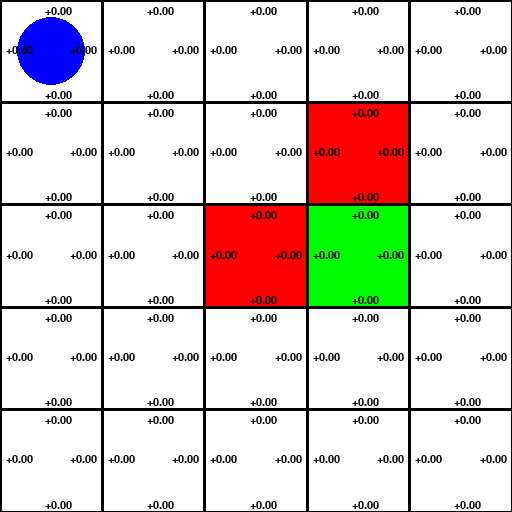

In [15]:
# Solution:
# Video:
recorder.make_video("videos/gridworld-traces.gif")

**Q:** Vary the trace parameter $\lambda$ and discuss its influence.

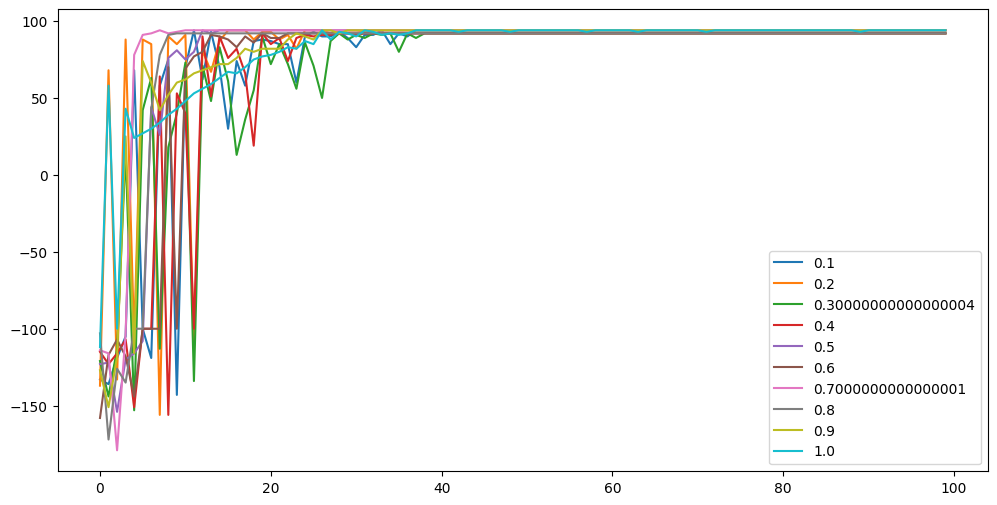

In [16]:
# Solution:
# Parameters
gamma = 0.99
#action_selection  = {'type': "egreedy", "param": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "param": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 100

list_returns = []

for lbda in np.linspace(0.1, 1.0, 10):

    # Create the environment
    env = GridWorldEnv()

    # Create the agent
    agent = QLambdaLearningAgent(env, gamma, lbda, action_selection, alpha)

    # Train the agent
    returns, steps = agent.train(nb_episodes)
    
    list_returns.append(returns)
    
plt.figure(figsize=(12, 6))
for idx, lbda in enumerate(np.linspace(0.1, 1.0, 10)):
    plt.plot(list_returns[idx], label=str(lbda))
plt.legend()
plt.show()

**A:** $\lambda$ should not be too high nor too low in order to speed up learning. It controls the bias/variance trade-off.

**Q:** Increase the size of Gridworld to 100x100 and observe how long it takes to learn the optimal strategy using eligibility traces or not.

```python
env = GridWorldEnv(size=100)
```

Comment on the **curse of dimensionality** and the interest of tabular RL for complex tasks with large state spaces and sparse rewards (e.g. robotics).

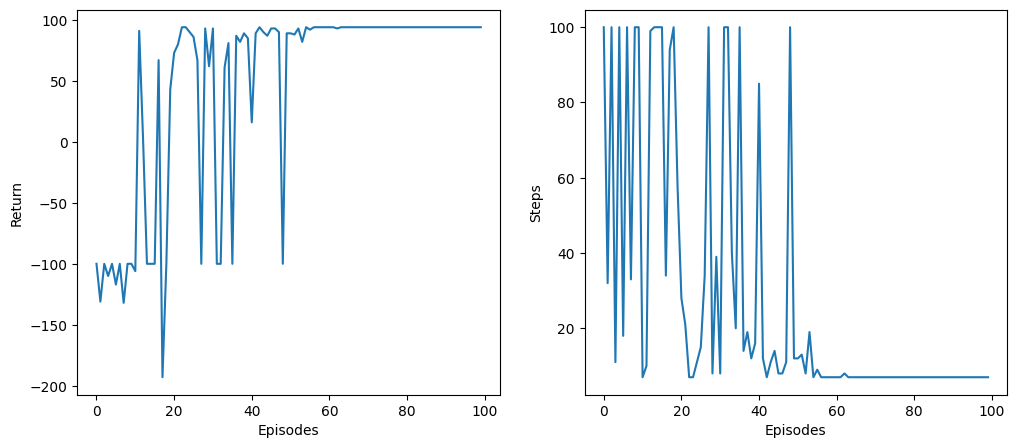

In [17]:
# Solution:
# Parameters
gamma = 0.99
lbda = 0.7
#action_selection  = {'type': "egreedy", "param": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "param": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 100

# Create the environment
env = GridWorldEnv(size=100)

# Create the agent
agent = SoftQLearningAgent(env, gamma, action_selection, alpha)
#agent = QLambdaLearningAgent(env, gamma, lbda, action_selection, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.subplot(122)
plt.plot(steps)
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.show()

**A:** When the Gridworld is too big, the likelihood to hit the target per chance when exploring is very low. There are a lot of unsuccessful trials before learning starts to occur. But it happens after a while.